In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import matplotlib.patheffects as pe

#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'

/home/thomas/anaconda3/envs/mantid/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


TwoTheta=88.99321272109671


Text(0.5, 0, '$Q$ at monochromator ($\\AA^{-1}$)')

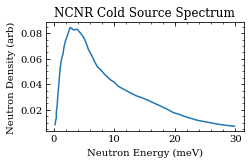

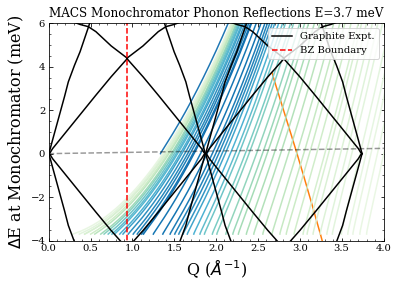

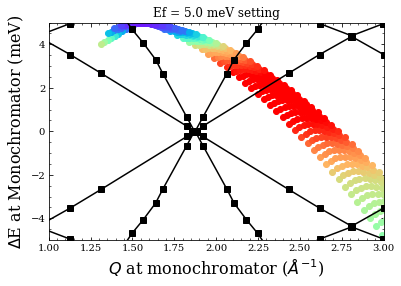

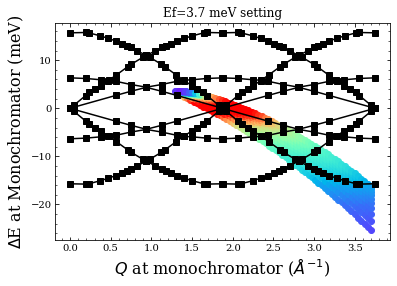

In [4]:
#Q is a linear walk from the gamma point to the A point

tau002 = 1.873
tauA = tau002/2.0
Q = np.linspace(0,3.0*tauA,500)
Ef = np.linspace(0,10,500)
lamf = 9.045 / np.sqrt(Ef)
Ei_set = 3.7
lami = 9.045 / np.sqrt(Ei_set)

#Import the cold source and dispersion relation
source = np.genfromtxt('Coldsource.csv',delimiter=',')
graphite = np.genfromtxt('graphitedispersion.csv',delimiter=',') #Format is Branch1 X, Branch1 Y, Branch2 X ...

#Get a callable interpolation for each of the four branches
branch1_interp = interpolate.interp1d(x=graphite[:,0],y=graphite[:,1])
branch2_interp = interpolate.interp1d(x=graphite[:,2],y=graphite[:,3])
branch3_interp = interpolate.interp1d(x=graphite[:,4],y=graphite[:,5])
branch4_interp = interpolate.interp1d(x=graphite[:,6],y=graphite[:,7])

#Normalize the cold source intensity
source_integral= np.trapz(x=source[:,0],y=source[:,1])
source[:,1]=source[:,1]/source_integral
#Get a spline
source_interp = interpolate.interp1d(x=source[:,0],y=source[:,1],fill_value='extrapolate')

fig,ax = plt.subplots(1,1,figsize=(3.54,2))
ax.plot(source[:,0],source[:,1])
ax.set_xlabel('Neutron Energy (meV)')
ax.set_ylabel('Neutron Density (arb)')
ax.set_title('NCNR Cold Source Spectrum')
fig.savefig('ncnr_coldsource_fig.pdf')
#Get a density of wavelengths for incident neutrons
lams = 9.045 / np.sqrt(source[:,1])
Eis = 81.82/(lams**2)
lams = 9.045 / np.sqrt(3.7)

#Determine the twoTheta of the monochromator setting
twoTheta = 2.0*np.arcsin(tau002*lami/(4.0*np.pi))
print('TwoTheta='+str(twoTheta*180.0/np.pi))
kf = 2.0*np.pi/lamf
ki = 2.0*np.pi/lams
Q = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoTheta))
plt.figure()
plt.plot(Q,Ef)
#Do lam/2 reflection
Q = np.sqrt((ki*2.0)**2 + kf**2 - 2.0*(ki*2.0)*kf*np.cos(twoTheta))
plt.plot(Q,Ei_set - Ef)
plt.xlabel('Q ($\AA^{-1}$)',fontsize=16)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)

def getcolor(val,vmin,vmax,cmap):
    cmap = matplotlib.cm.get_cmap(cmap)
    norm_val = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    rgba = cmap(norm_val(val))
    return rgba
#Iterate through all possible source neutrons, plot lines like the ones above. 
#Their color will be determined by their neutron weight.
for i in range(len(source[:,1])):
    energy = source[i,0]
    weight = source[i,1]
    lam = 9.045/np.sqrt(energy)
    ki = 2.0*np.pi/lam
    Q = np.sqrt(ki**2 + kf**2 - 2.0*ki*kf*np.cos(twoTheta))
    plt.plot(Q,Ef-Ei_set,color=getcolor(weight,0,0.1,'GnBu'))

#Overplot the disperion relationship of graphite
disp_marker=''
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker=disp_marker,color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker=disp_marker,color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker=disp_marker,color='k',ls='-')

plt.plot(np.ones(100)*tauA,np.linspace(-20,20,100),'r--',label='BZ Boundary')
plt.plot(np.linspace(0,6,100),'k--',alpha=0.4)
plt.legend(loc=1)
plt.title('MACS Monochromator Phonon Reflections E='+str(Ei_set)+' meV')
plt.xlim(0,4)
plt.ylim(-4,6)

#Write a function to determine for a given Ei, the weight of the allowed phonon branches and their overall cross section
def calc_graphite(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    twoTheta = 2.0*np.arcsin(tau002*lami_set/(4.0*np.pi))  

    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    Qmax = 3.7#np.sqrt(0.12**2 + kf**2 - 2.0*0.12*kf*np.cos(twoTheta)**2)
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei
    Q = np.linspace(Qmin+0.01,Qmax,60) #Allowed Q's based on kinematics
    kis = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    

    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.08,cmap='rainbow')
    for i in range(len(colors)):
        plt.plot(Q[i],Ef-Eis[i],c=colors[i],ls='-',marker='o')
    #Get a weighted phonon cross section for the 
    
        
        
plt.figure()
for Ei in np.linspace(5,8.0,10):
    calc_graphite(Ei,5.0)
plt.title('Ef = 5.0 meV setting')
#Overplot the disperion relationship of graphite

for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
plt.ylim(-5,5)
plt.xlim(1,3)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)
plt.xlabel('$Q$ at monochromator ($\AA^{-1}$)',fontsize=16) 
    
plt.figure()
for Ei in np.linspace(3.0,5.0,10):
    calc_graphite(Ei,3.7)
plt.title('Ef=3.7 meV setting')

#Overplot the disperion relationship of graphite
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-',label='Graphite Expt.')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    else:
        plt.plot(branchX,branchY,marker='s',color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    plt.plot(-1.0*branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(branchX+2.0*tauA,branchY,marker='s',color='k',ls='-')
    plt.plot(-1.0*branchX+4.0*tauA,branchY,marker='s',color='k',ls='-')
#plt.xlim(1,3)
#plt.ylim(-2,2)
plt.ylabel('$\Delta$E at Monochromator (meV)',fontsize=16)
plt.xlabel('$Q$ at monochromator ($\AA^{-1}$)', fontsize=16)

## Simple one phonon neutron cross section is given by (Squires):

$$\frac{d^2\sigma}{d\Omega dE}_{coh 1 ph} = \frac{2}{3}\frac{k'}{k_i}\frac{\sigma_{coh}}{4\pi M}e^{-2W}|F(\tau)|^2 \frac{Q^2}{\omega}$$

Assuming polarization terms sum to 2/3

So, for a given energy transfer we can integrate over the full allowed spectrum and find a lineshape that matches the experimentally observed one. We really only care about the negative transfer side.

In [4]:
def calc_graphite_num(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    print('Ei='+str(Ei_set))
    print('twoTheta='+str(180.0*twoTheta/np.pi))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=5.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,100) #Allowed Q's based on kinematics
    kis_minus = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

def calc_graphite_num_plus(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    print('Ei='+str(Ei_set))
    print('twoTheta='+str(180.0*twoTheta/np.pi))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=5.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,100) #Allowed Q's based on kinematics
    kis = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    #kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

def calc_graphite_num_minus(Ei_set,Ef):
    #Given incident energy  
    
    lami_set = 9.045 / np.sqrt(Ei_set) #given Ei setting
    lamf = 9.045 / np.sqrt(Ef) #Defined by analyzer setting, fixed.
    #Ef is given by the specified energy transfer
    ki_set = 2.0*np.pi/lami_set
    kf = 2.0*np.pi/ lamf
    #Determine the twoTheta of the monochromator setting, fixed
    tau002 = 1.873
    #For monochromator reflection kf = ki
    twoTheta = np.arccos((ki_set**2 + ki_set**2 - tau002**2) / (2.0*ki_set*ki_set))
    print('Ei='+str(Ei_set))
    print('twoTheta='+str(180.0*twoTheta/np.pi))
    #Based on restrictions of twotheta, kf, we can solve for the min and max allowed Q's
    #Qmax = 0.99*np.sqrt(ki_set**2 + ki_set**4 *np.cos(twoTheta)**2 -ki_set**2 * np.cos(twoTheta)**2)
    Qmax=5.0
    Qmin = np.sqrt(kf**2 - kf**2 * np.cos(twoTheta)**2)
    #Now that we have two theta and kf, for a given range of Q we can solve for ki / allowed Ei,
    #Q_mono ^2 = ki^2 + kf^22 _ 2k_i k_f cos(2theta), solve for ki using particular Q_mono
    Q = np.linspace(Qmin+0.01,Qmax,100) #Allowed Q's based on kinematics
    #kis_minus = kf * np.cos(twoTheta) - np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)
    kis = kf * np.cos(twoTheta) + np.sqrt(Q**2 + kf**2 *np.cos(twoTheta)**2 - kf**2)

    allowed_lams = 2.0*np.pi/kis
    Eis = 81.82/(allowed_lams**2)
    
    deltaE=Eis-Ef
    weights = source_interp(x=Eis)
    colors = getcolor(weights,vmin=0.0,vmax=0.1,cmap='rainbow')
    return Q,deltaE,weights,colors

Ei=5.000000000000002
twoTheta=74.15699278173555
Ei=5.000000000000002
twoTheta=74.15699278173555
Ei=4.900000000000001
twoTheta=75.03874839307744
Ei=4.900000000000001
twoTheta=75.03874839307744
Ei=4.800000000000001
twoTheta=75.95340692538099
Ei=4.800000000000001
twoTheta=75.95340692538099
Ei=4.700000000000001
twoTheta=76.90311660561832
Ei=4.700000000000001
twoTheta=76.90311660561832
Ei=4.600000000000001
twoTheta=77.89023248077338
Ei=4.600000000000001
twoTheta=77.89023248077338
Ei=4.500000000000001
twoTheta=78.91734345761323
Ei=4.500000000000001
twoTheta=78.91734345761323
Ei=4.4
twoTheta=79.98730391592643
Ei=4.4
twoTheta=79.98730391592643
Ei=4.300000000000001
twoTheta=81.10327086425521
Ei=4.300000000000001
twoTheta=81.10327086425521
Ei=4.200000000000001
twoTheta=82.26874785845533
Ei=4.200000000000001
twoTheta=82.26874785845533
Ei=4.1000000000000005
twoTheta=83.48763723309955
Ei=4.1000000000000005
twoTheta=83.48763723309955
Ei=4.0
twoTheta=84.764302632791
Ei=4.0
twoTheta=84.764302632791
Ei

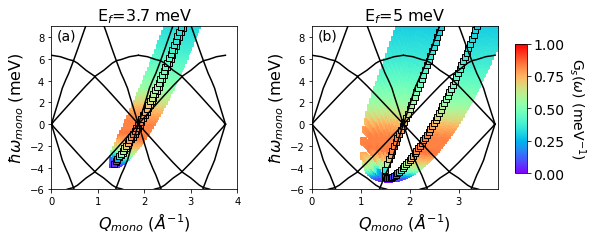

In [11]:

fig,ax=plt.subplots(1,2,figsize=(8,3))
fig.subplots_adjust(wspace=0.4)
#Overplot the disperion relationship of graphite



out_arr_3p7=[]
for Ei in np.arange(3.7,3.7+1.4,0.1)[::-1]:
    Ef=3.7
    qout,deltaE,weights,colors = calc_graphite_num_plus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==3.7:
            ax[0].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[0].plot(qout[i],deltaE[i],color=colors[i],marker='s')
    #Do this for the negative solution for ki as well.
    qout,deltaE,weights,colors = calc_graphite_num_minus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==3.7:
            ax[0].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[0].plot(qout[i],deltaE[i],color=colors[i],marker='s')


ax[0].set_xlim(0,4)
ax[0].set_ylim(-6,9)
ax[0].set_title('E$_f$=3.7 meV',fontsize=16)
ax[0].set_ylabel('$\hbar\omega_{mono}$ (meV)',fontsize=16)
ax[0].set_xlabel('$Q_{mono}$ ($\AA^{-1}$)', fontsize=16)        
ax[0].text(0.03,0.9,'(a)',fontsize=14,transform=ax[0].transAxes,horizontalalignment='left',verticalalignment='bottom')
ax[1].text(0.03,0.9,'(b)',fontsize=14,transform=ax[1].transAxes,horizontalalignment='left',verticalalignment='bottom')

out_arr_3p7=np.array(out_arr_3p7)

out_arr_5p0 = []
for Ei in np.arange(5.0,15.0,0.5)[::-1]:
    Ef=5.0
    qout,deltaE,weights,colors = calc_graphite_num_plus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==5.0:
            ax[1].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[1].plot(qout[i],deltaE[i],color=colors[i],marker='s')
    #Do this for the negative solution for ki as well.
    qout,deltaE,weights,colors = calc_graphite_num_minus(Ei,Ef)
    for i in range(len(qout)):
        if Ei==5.0:
            ax[1].plot(qout[i],deltaE[i],mec='k',marker='s',mfc=colors[i])
        else:
            ax[1].plot(qout[i],deltaE[i],color=colors[i],marker='s')

ax[1].set_xlim(0,3.8)
ax[1].set_ylim(-6,9)
ax[1].set_title('E$_f$=5 meV',fontsize=16)
ax[1].set_ylabel('$\hbar\omega_{mono}$ (meV)',fontsize=16)
ax[1].set_xlabel('$Q_{mono}$ ($\AA^{-1}$)', fontsize=16)        


phonon_marker=' '
for i in [0,1,2,3]:
    branchX = graphite[:,2*i]
    branchY = graphite[:,2*i +1]
    if i ==0:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',label='Graphite Expt.')
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-',label='Graphite Expt.')
    else:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')

    #Repeat this four times to accomodate the relevant range of Q space
    ax[0].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[0].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[0].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    #Reflect these points about y-axis
    branchX = graphite[:,2*i]
    branchY = -1.0*graphite[:,2*i +1]
    if i ==0:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')

    else:
        ax[0].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')
        ax[1].plot(branchX,branchY,marker=phonon_marker,color='k',ls='-')
    #Repeat this four times to accomodate the relevant range of Q space
    ax[0].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[0].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[0].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(-1.0*branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(branchX+2.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    ax[1].plot(-1.0*branchX+4.0*tauA,branchY,marker=phonon_marker,color='k',ls='-')
    
#Add a colorbar 
cbar_ax = fig.add_axes([0.93,0.2,0.02,0.6])
cbar_ax.tick_params(labelleft=False,labelright=True,labelbottom=False,labeltop=False)
cbar_ax.tick_params(labelsize=14)
cmap=plt.get_cmap('rainbow')
norm=matplotlib.colors.Normalize(vmin=0.0,vmax=1)
cbar_ax.text(5.45,0.5,'G$_s$($\omega$) (meV$^{-1}$)',rotation=-90,fontsize=14,transform=cbar_ax.transAxes,\
            verticalalignment='center',horizontalalignment='center')
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
sm.set_array([])
cb = matplotlib.colorbar.ColorbarBase(cbar_ax,cmap=cmap,norm=norm,orientation='vertical')
#fig.savefig('MACS_mono_plot.pdf',bbox_inches='tight')
fig.savefig('MACS_mono_plot.png',bbox_inches='tight')
plt.show()